In [3]:
import torch
from torch.utils.data import DataLoader, RandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from rich.progress import track

from src.dataset import WeatherDataset
from src.weather.module import LitWeatherModule

%load_ext autoreload
%autoreload 2

# Training 

In [47]:
train_dataset= WeatherDataset.from_file("data/weather/20260108_00z/weather_train.npz")

sampler = RandomSampler(
    train_dataset,
    replacement=True,
    num_samples = 500_000
)

train_loader = DataLoader(train_dataset, batch_size = 5000, sampler = sampler, drop_last=True)

In [80]:
model = LitWeatherModule(
    num_atoms=256, 
    mlp_sizes=5*[256],
    output_dim = 1,
    bias = True,
    L_init =20,
    omega0_pe=15.0,
    omega0_mlp = 1.0,
    lr = 1e-3
)


ckpt = ModelCheckpoint(
    monitor="loss",
    mode = "min",
    save_last=True,
    filename = "best",
    enable_version_counter=False,
)



In [81]:
theme = RichProgressBarTheme(metrics_format="{:.3f}")

trainer = pl.Trainer(
    max_epochs=5000,
    accelerator="gpu",
    logger = False,
    precision = "32",
    callbacks=[RichProgressBar(theme=theme), ckpt]
)

trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ WeatherModule │  329 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 329 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 329 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/Users/thanon/Desktop/Rennes/Rennes-code/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=5000` reached.


# Results


In [ ]:
model = LitWeatherModule.load_from_checkpoint("checkpoints/best_weather.ckpt").cpu()

In [5]:
test_dataset = WeatherDataset.from_file("data/weather/20260108_00z/weather_test.npz")
test_loader = DataLoader(test_dataset, batch_size = 512)

preds = []

for xb, _ in track(test_loader):
    with torch.no_grad():
        ypred = model(xb)
        preds.append(ypred)

ypreds = torch.cat(preds).reshape(test_dataset.get_shape())
gt = test_dataset.y.reshape(test_dataset.shape)
time = test_dataset.time

snr = 10 * torch.log10(gt.pow(2).mean(dim = (1, 2)) / (gt - ypreds).pow(2).mean(dim = (1, 2)))

/Users/thanon/Desktop/Rennes/Rennes-code/.venv/lib/python3.11/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

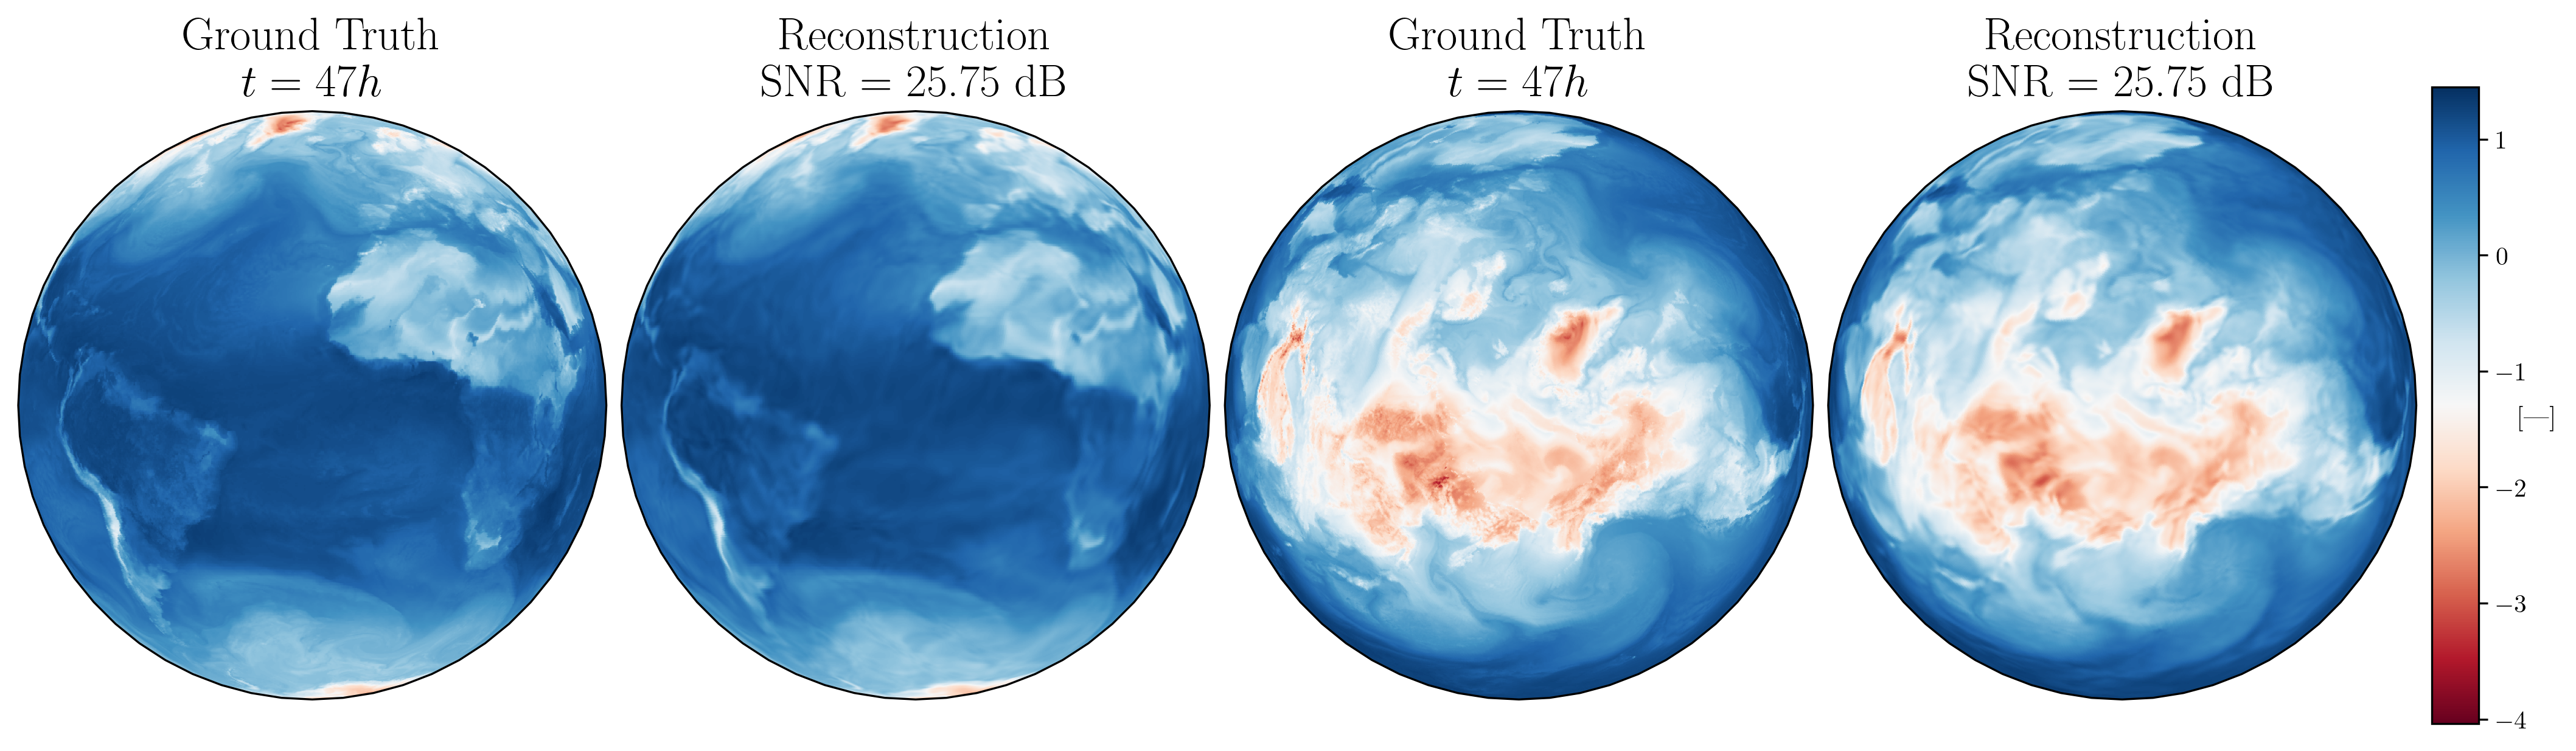

In [123]:
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- Figure + layout ---
fig = plt.figure(dpi=300, figsize=(14, 4), constrained_layout=True)

gs = gridspec.GridSpec(
    1, 5,
    figure=fig,
    width_ratios=[1.0, 1.0, 1.0, 1.0, 0.08],
    wspace=0.01,
    hspace=0.0,
)

proj_eq = ccrs.Orthographic(central_longitude=-200, central_latitude=0)
proj_np = ccrs.Orthographic(central_longitude=0, central_latitude=90)
data_crs = ccrs.PlateCarree()

ax1 = fig.add_subplot(gs[0, 0], projection=proj_eq)
ax2 = fig.add_subplot(gs[0, 1], projection=proj_eq)
ax3 = fig.add_subplot(gs[0, 2], projection=proj_np)
ax4 = fig.add_subplot(gs[0, 3], projection=proj_np)

axes = (ax1, ax2, ax3, ax4)

# --- Color scale ---
vmin = min(torch.min(ypreds), torch.min(gt))
vmax = max(torch.max(ypreds), torch.max(gt))

imshow_kw = dict(cmap="RdBu", vmin=vmin, vmax=vmax, origin="lower", transform=data_crs)

# --- Initial frame ---
im1 = ax1.imshow(gt[0], **imshow_kw)
im2 = ax2.imshow(ypreds[0], **imshow_kw)
im3 = ax3.imshow(gt[0], **imshow_kw)
im4 = ax4.imshow(ypreds[0], **imshow_kw)

ax1.set_title("Ground truth\n" + r"$t = 1 h$", fontweight="bold", fontsize=18)
ax2.set_title(f"Prediction\n SNR = {snr[0]:.2f} dB", fontweight="bold", fontsize=18)
ax3.set_title("Ground truth\n" + r"$t = 1 h$", fontweight="bold", fontsize=18)
ax4.set_title(f"Prediction\n SNR = {snr[0]:.2f} dB", fontweight="bold", fontsize=18)

# --- Colorbar ---
cax = fig.add_subplot(gs[0, 4])
cbar = fig.colorbar(im1, cax=cax, orientation="vertical", pad=1.0)
cbar.set_label("[---]", rotation=0)

plt.savefig("attributes/weather.pdf")

def update(frame):
    for ax in axes:
        ax.clear()

    ax1.imshow(gt[frame], **imshow_kw)
    ax2.imshow(ypreds[frame], **imshow_kw)
    ax3.imshow(gt[frame], **imshow_kw)
    ax4.imshow(ypreds[frame], **imshow_kw)

    t_hours = int(48 * time[frame])
    ax1.set_title("Ground Truth\n" + fr"$t = {t_hours}h$", fontsize=18, fontweight="bold")
    ax2.set_title(f"Reconstruction\n SNR = {snr[frame]:.2f} dB", fontsize=18, fontweight="bold")
    ax3.set_title("Ground Truth\n" + fr"$t = {t_hours}h$", fontsize=18, fontweight="bold")
    ax4.set_title(f"Reconstruction\n SNR = {snr[frame]:.2f} dB", fontsize=18, fontweight="bold")

    return []


ani = FuncAnimation(fig, update, frames=len(time), blit=True)
ani.save("attributes/weather.gif", writer="ffmpeg", fps=10)

HTML(ani.to_html5_video())
